# Machine Learning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (GridSearchCV, train_test_split, cross_val_score, KFold)
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns 

In [2]:
# import warnings filter
from warnings import simplefilter, filterwarnings
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
filterwarnings("error", message=".*check_inverse*.", category=UserWarning, append=False)

In [3]:
df_identity = pd.read_csv('train_identity.csv')
df_transaction = pd.read_csv('train_transaction.csv')

In [4]:
df_identity.select_dtypes(include=object).head()

,id_12,id_15,id_16,id_23,id_27,id_28,id_29,id_30,id_31,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,NotFound,New,NotFound,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,NotFound,New,NotFound,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,NotFound,Found,Found,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,F,F,T,T,desktop,Windows
3,NotFound,New,NotFound,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,F,F,T,T,desktop,NaN
4,NotFound,Found,Found,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [5]:
df_transaction.select_dtypes(include=object).head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# The unique values for the below mentioned columns are 'Found', 'NotFound' or 'New'.
# Hence, updating the string values 'New', 'Found' and 'NotFound' to
# '2', '1' and '0' respectively.
mapValues1 = {'New': 2, 'Found': 1, 'NotFound': 0}
df_identity['id_12'] = df_identity['id_12'].map(mapValues1)
df_identity['id_15'] = df_identity['id_15'].map(mapValues1)
df_identity['id_16'] = df_identity['id_16'].map(mapValues1)
df_identity['id_27'] = df_identity['id_27'].map(mapValues1)
df_identity['id_28'] = df_identity['id_28'].map(mapValues1)
df_identity['id_29'] = df_identity['id_29'].map(mapValues1)

# For below mentioned columns updating the string values 'T' and 'F' to
# '1' and '0' respectively.
mapValues2 = {'T': 1, 'F': 0}
df_identity['id_35'] = df_identity['id_35'].map(mapValues2)
df_identity['id_36'] = df_identity['id_36'].map(mapValues2)
df_identity['id_37'] = df_identity['id_37'].map(mapValues2)
df_identity['id_38'] = df_identity['id_38'].map(mapValues2)

# Since, most of the columns have values as 'NaN' where 'id_35' is equal to 'NaN', hence
# removing those rows from the dataset. This removes only 2.25% of total data
#df1 = df1[df1['id_35'].notnull()]

# Replacing the NaN values of 'DeviceType' column with 'desktop' because as per analysis
# for the mentioned 'DeviceInfo' and its combination with column 'id_31', the device type is equal to 'desktop'
df_identity['DeviceType'].loc[df_identity['DeviceInfo'].isin(['Windows','rv:11.0','Trident/7.0'])] = 'desktop'

####################################################################################

# Adding new column TransactionDay by calculating the value from TransactionDT column
# math.ceil returns smallest integer greater than the provided value.
df_transaction['TransactionDay']=np.ceil(df_transaction['TransactionDT']/60/60/24).astype('int')

# Replacing NaN values of card4 based on common card1 values
df_transaction.loc[df_transaction.card4.isnull(), 'card4'] = \
df_transaction.loc[df_transaction.card4.isnull(), 'card1'].map(df_transaction[df_transaction.card4.notnull()] \
                    [['card1','card4']].sort_values('card1').drop_duplicates().set_index('card1')['card4'])

#Replace few card6 values to valid specific values
df_transaction.card6 = df_transaction.card6.replace(to_replace=['debit or credit'], value=['debit'])
df_transaction.card6 = df_transaction.card6.replace(to_replace=['charge card'], value=['credit'])

# For below mentioned columns updating the string values 'T' and 'F' to
# '1' and '0' respectively.
df_transaction['M1'] = df_transaction['M1'].map(mapValues2)
df_transaction['M2'] = df_transaction['M2'].map(mapValues2)
df_transaction['M3'] = df_transaction['M3'].map(mapValues2)
df_transaction['M5'] = df_transaction['M5'].map(mapValues2)
df_transaction['M6'] = df_transaction['M6'].map(mapValues2)
df_transaction['M7'] = df_transaction['M7'].map(mapValues2)
df_transaction['M8'] = df_transaction['M8'].map(mapValues2)
df_transaction['M9'] = df_transaction['M9'].map(mapValues2)


# label encoding the data
le = LabelEncoder() 
df_identity['DeviceType']= le.fit_transform(df_identity['DeviceType'].astype(str)) 
df_identity['id_23']= le.fit_transform(df_identity['id_23'].astype(str)) 
df_transaction['card4']= le.fit_transform(df_transaction['card4'].astype(str)) 
df_transaction['card6']= le.fit_transform(df_transaction['card6'].astype(str)) 
df_transaction['ProductCD']= le.fit_transform(df_transaction['ProductCD'].astype(str)) 

//anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
# Creating main dataset by merging both the DataFrames created from two csv files
dataset = pd.merge(df_transaction,df_identity,on='TransactionID',how='left')

In [8]:
dataset.shape
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Columns: 435 entries, TransactionID to DeviceInfo
dtypes: float64(419), int64(8), object(8)
memory usage: 1.9+ GB


In [9]:
dataset.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,4,13926,NaN,150.0,1,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,4,2755,404.0,150.0,2,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,4,4663,490.0,150.0,4,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,4,18132,567.0,150.0,2,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,1,4497,514.0,150.0,2,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,1.0,0.0,1.0,1.0,1.0,SAMSUNG SM-G892A Build/NRD90M


In [10]:
dataset.select_dtypes(include=object).head()

,P_emaildomain,R_emaildomain,M4,id_30,id_31,id_33,id_34,DeviceInfo
0,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
1,gmail.com,NaN,M0,NaN,NaN,NaN,NaN,NaN
2,outlook.com,NaN,M0,NaN,NaN,NaN,NaN,NaN
3,yahoo.com,NaN,M0,NaN,NaN,NaN,NaN,NaN
4,gmail.com,NaN,NaN,Android 7.0,samsung browser 6.2,2220x1080,match_status:2,SAMSUNG SM-G892A Build/NRD90M


In [11]:
def coeff_of_determination(X,Y):
    # Model Intialization
    reg = LogisticRegression()
    # Data Fitting
    reg = reg.fit(X, Y)

    # Model Evaluation
    r2 = reg.score(X, Y)
    return r2

In [12]:
X = np.array([dataset.card1, dataset.C1, dataset.TransactionDay]).T
Y = np.array(dataset.isFraud)
coeff_of_determination(X,Y)

0.9650099908558268

__Using Imputer for mapping NaN values with respective median values.__

In [13]:
Xcols = dataset.drop(['isFraud'],axis=1).select_dtypes(exclude=[object])
y = dataset.isFraud
Xlr, Xtestlr, ylr, ytestlr = train_test_split(Xcols, y, random_state=5,test_size=0.3, stratify = y)
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer.fit(Xcols)
X = imputer.transform(Xcols)

### 1) Applying Logistic Regression to the data

In [14]:
logReg = LogisticRegression(solver='liblinear')
steps = [('imputation',imputer),('logistic_regression',logReg)]
pipeline = Pipeline(steps)
pipeline.fit(Xlr,ylr)
pipeline.score(Xtestlr, ytestlr)

0.9649416917849201

__From below details of the model we can see that the `recall` value is 0 which indicates that the model does not do well in identifying the relevant instance of classification model and in this case which is identifying the fraud transactions.__

Train accuracy: 0.9649618508967579
Test accuracy: 0.9649416917849201
The confusion matrix is :
[[170947     16]
 [  6195      4]]
The classification report is :
              precision    recall  f1-score   support

           0       0.97      1.00      0.98    170963
           1       0.20      0.00      0.00      6199

    accuracy                           0.96    177162
   macro avg       0.58      0.50      0.49    177162
weighted avg       0.94      0.96      0.95    177162

The roc_auc_score is : 0.6394527440284451


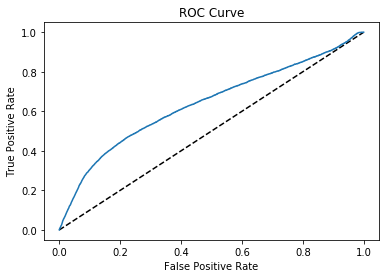

In [15]:
ypred = pipeline.predict(Xtestlr)
y_pred_prob = pipeline.predict_proba(Xtestlr)[:,1]
fpr, tpr, threshold = roc_curve(ytestlr, y_pred_prob)

# Print the accuracy and other details.
print("Train accuracy: {}".format(accuracy_score(pipeline.predict(Xlr), ylr)))
print("Test accuracy: {}".format(accuracy_score(ypred, ytestlr)))
print("The confusion matrix is :")
print(confusion_matrix(ytestlr, ypred))
print("The classification report is :")
print(classification_report(ytestlr, ypred))
print("The roc_auc_score is : {}".format(roc_auc_score(ytestlr, y_pred_prob)))

# Plot ROC curve
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')

### 2) Appyling Logistic Regression along with PCA (Principal Component Analysis)

In [16]:
pca = PCA()
# set the tolerance to a large value to make the example faster
logistic = LogisticRegression()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])
# Plot the PCA spectrum
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0, 0.5, 'explained_variance_')

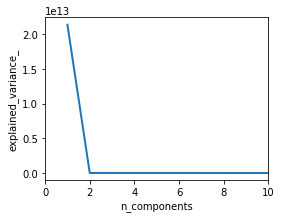

In [17]:
plt.figure(1, figsize=(4, 3))
plt.plot(np.arange(1, pca.n_components_ + 1),
         pca.explained_variance_, linewidth=2)
plt.xlim([0,10])
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

### 3) Finding proper value for n_components field of PCA

In [18]:
param_grid = {
    'pca__n_components': [2, 5, 10, 20, 30]
}
search = GridSearchCV(pipe, param_grid)
search.fit(X, y)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Best parameter (CV score=0.608):
{'pca__n_components': 2}


### 4) Fitting and predicting with PCA and Logistic Regression using Pipeline

Train accuracy: 0.965010232765169
Test accuracy: 0.9650094264006954
The confusion matrix is :
[[170963      0]
 [  6199      0]]
The classification report is :


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    170963
           1       0.00      0.00      0.00      6199

    accuracy                           0.97    177162
   macro avg       0.48      0.50      0.49    177162
weighted avg       0.93      0.97      0.95    177162

The roc_auc_score is : 0.5413558572487036


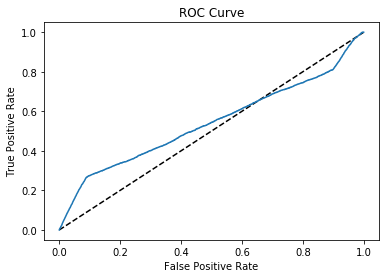

In [30]:

# Define a pipeline to search for the best combination of PCA truncation
# and classifier regularization.
pca = PCA(n_components = 2)
logistic = LogisticRegression(solver='liblinear')
pipeL = Pipeline(steps=[('imputation',imputer), ('pca', pca), ('logistic', logistic)])
pipeL.fit(Xlr, ylr)
ypred = pipeL.predict(Xtestlr)
y_pred_prob = pipeL.predict_proba(Xtestlr)[:,1]
fpr, tpr, threshold = roc_curve(ytestlr, y_pred_prob)

# Print the accuracy and other details.
print("Train accuracy: {}".format(accuracy_score(pipeL.predict(Xlr), ylr)))
print("Test accuracy: {}".format(accuracy_score(ypred, ytestlr)))
print("The confusion matrix is :")
print(confusion_matrix(ytestlr, ypred))
print("The classification report is :")
print(classification_report(ytestlr, ypred))
print("The roc_auc_score is : {}".format(roc_auc_score(ytestlr, y_pred_prob)))

# Plot ROC curve
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')

### 5) Performing under sampling (NearMiss). Here, we are performing under sampling during Cross validation.

In [20]:
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline as make_pipeline_imb

nm_cv_accuracy = []               
nm_cv_auc = []              

nm_cv_conf_matrices = []

X_train, X_test, y_train, y_test = train_test_split(Xcols, y, random_state=5,test_size=0.3, stratify = y)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

nfold = 5
for train, test in KFold(nfold).split(X_train):
    pipeline = make_pipeline_imb(SimpleImputer(missing_values = np.nan, strategy = 'median'), NearMiss(), LogisticRegression(solver='liblinear'))
    nearmiss_model = pipeline.fit(X_train[train], y_train[train])
    nearmiss_predictions = nearmiss_model.predict(X_train[test])
    
    #scoring metrics
    nm_cv_accuracy.append(pipeline.score(X_train[test], y_train[test]))
    nm_cv_auc.append(roc_auc_score(y_train[test], nearmiss_predictions))
    
    #confusion matrices
    nm_cv_conf_matrices.append(confusion_matrix(y_train[test], nearmiss_predictions))

    
print('Accuracy: {}'.format(np.mean(nm_cv_accuracy)))
print('AUC: {}'.format(np.mean(nm_cv_auc)))

Accuracy: 0.7337303892974735
AUC: 0.720473905319057


In [21]:
print("Test accuracy: {}".format(accuracy_score(pipeline.predict(X_test), y_test)))

Test accuracy: 0.7344577279552048


NearMiss Confusion Matrices
............................................................
[[57884 21873]
 [  788  2131]]
[[58074 21704]
 [  851  2047]]
[[59833 19957]
 [  941  1945]]
[[58284 21539]
 [  800  2052]]
[[59018 20748]
 [  869  2040]]


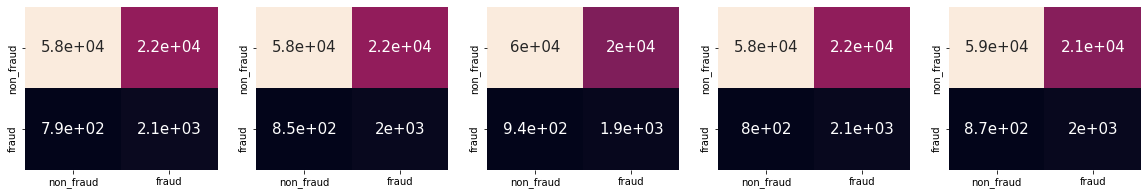

In [22]:
fig, ax = plt.subplots(figsize=(20, 3), nrows=1, ncols=5)
tick_labels = ['non_fraud', 'fraud']
k = 0
print('NearMiss Confusion Matrices')
print('.'*60)
#the first 5 confusion matrices of the 10
for nearmiss_conf_matrix in nm_cv_conf_matrices:
    print(nearmiss_conf_matrix)
    ax1 = sns.heatmap(nearmiss_conf_matrix, cbar=False, xticklabels=tick_labels, \
                      yticklabels=tick_labels, ax=ax[k], annot=True, annot_kws={'size' : 15})
    #ax1.set_ylabel('Actual Labels')
    #ax1.set_xlabel('Predicted Labels')
    k= k + 1


### 6) Performing over sampling (SMOTE). Here, we are performing over sampling after spitting.

In [23]:
print("Before resampling, counts of frauds '1': {}".format(sum(y == 1))) 
print("Before resampling, counts of non-frauds '0': {} \n".format(sum(y == 0))) 

#SMOTE (Synthetic Minority Oversampling Technique) – Oversampling
from imblearn.over_sampling import SMOTE 

imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer.fit(Xcols)
X = imputer.transform(Xcols)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=5,test_size=0.3, stratify = y)
sm = SMOTE(random_state = 2) 

Xtrain_overres, ytrain_overres = sm.fit_sample(Xtrain, ytrain) 
  
print('After OverSampling, the shape of train_X: {}'.format(Xtrain_overres.shape)) 
print('After OverSampling, the shape of train_y: {} \n'.format(ytrain_overres.shape)) 
  
print("After OverSampling, counts of frauds '1': {}".format(sum(ytrain_overres == 1))) 
print("After OverSampling, counts of non-frauds '0': {}".format(sum(ytrain_overres == 0)))

Before resampling, counts of frauds '1': 20663
Before resampling, counts of non-frauds '0': 569877 

After OverSampling, the shape of train_X: (797828, 426)
After OverSampling, the shape of train_y: (797828,) 

After OverSampling, counts of frauds '1': 398914
After OverSampling, counts of non-frauds '0': 398914


//anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Train accuracy: 0.6759389241791464
Test accuracy: 0.6553832085887493
The confusion matrix is :
[[111812  59151]
 [  1902   4297]]
The classification report is :
              precision    recall  f1-score   support

           0       0.98      0.65      0.79    170963
           1       0.07      0.69      0.12      6199

    accuracy                           0.66    177162
   macro avg       0.53      0.67      0.45    177162
weighted avg       0.95      0.66      0.76    177162

The roc_auc_score is : 0.7487818114812206


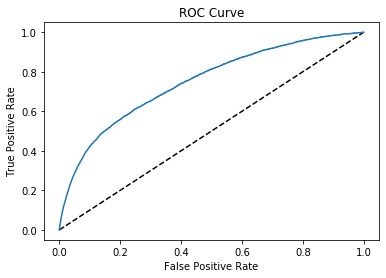

In [24]:
clf = LogisticRegression(solver='liblinear')
clf.fit(Xtrain_overres, ytrain_overres)
y_res_pred = clf.predict(Xtest)
y_pred_prob = clf.predict_proba(Xtest)[:,1]
fpr, tpr, threshold = roc_curve(ytest, y_pred_prob)

# Print the accuracy and other details.
print("Train accuracy: {}".format(accuracy_score(clf.predict(Xtrain_overres), ytrain_overres)))
print("Test accuracy: {}".format(accuracy_score(y_res_pred, ytest)))
print("The confusion matrix is :")
print(confusion_matrix(ytest, y_res_pred))
print("The classification report is :")
print(classification_report(ytest, y_res_pred))
print("The roc_auc_score is : {}".format(roc_auc_score(ytest, y_pred_prob)))

# Plot ROC curve
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')

### 7) Applying XGBoost

__XGBoost is an optimized distributed gradient boosting library designed to be highly efficient, flexible and portable. It implements machine learning algorithms under the Gradient Boosting framework. XGBoost provides a parallel tree boosting (also known as GBDT, GBM) that solve many data science problems in a fast and accurate way.__

Train accuracy: 0.8527618789582416
Test accuracy: 0.850887887921789
The confusion matrix is :
[[145960  25003]
 [  1414   4785]]
The classification report is :
              precision    recall  f1-score   support

           0       0.99      0.85      0.92    170963
           1       0.16      0.77      0.27      6199

    accuracy                           0.85    177162
   macro avg       0.58      0.81      0.59    177162
weighted avg       0.96      0.85      0.89    177162

The roc_auc_score is : 0.8921533415282722


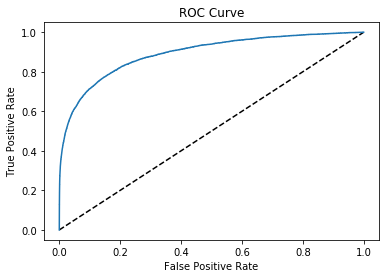

In [25]:
from xgboost import XGBClassifier
from xgboost import plot_importance

Xcols = dataset.drop(['isFraud'],axis=1).select_dtypes(exclude=[object])
y = dataset.isFraud
XG_train, XG_test, yg_train, yg_test = train_test_split(Xcols, y, random_state=5,test_size=0.3, stratify = y)

#scale_pos_weight [default=1] : Control the balance of positive and negative weights, 
#useful for unbalanced classes. 
#A typical value to consider: sum(negative instances) / sum(positive instances).
ratio = float(np.sum(y == 0)) / np.sum(y==1)

XGModel = XGBClassifier(top_k = 2, scale_pos_weight = ratio)
XGModel.fit(XG_train,yg_train)

y_XG_pred = XGModel.predict(XG_test)

features = XGModel.feature_importances_
yg_pred_prob = XGModel.predict_proba(XG_test)[:,1]
fpr, tpr, threshold = roc_curve(yg_test, yg_pred_prob)

# Print the accuracy and other details.
print("Train accuracy: {}".format(accuracy_score(XGModel.predict(XG_train), yg_train)))
print("Test accuracy: {}".format(accuracy_score(y_XG_pred, yg_test)))
print("The confusion matrix is :")
print(confusion_matrix(yg_test, y_XG_pred))
print("The classification report is :")
print(classification_report(yg_test, y_XG_pred))
print("The roc_auc_score is : {}".format(roc_auc_score(yg_test, yg_pred_prob)))

# Plot ROC curve
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')

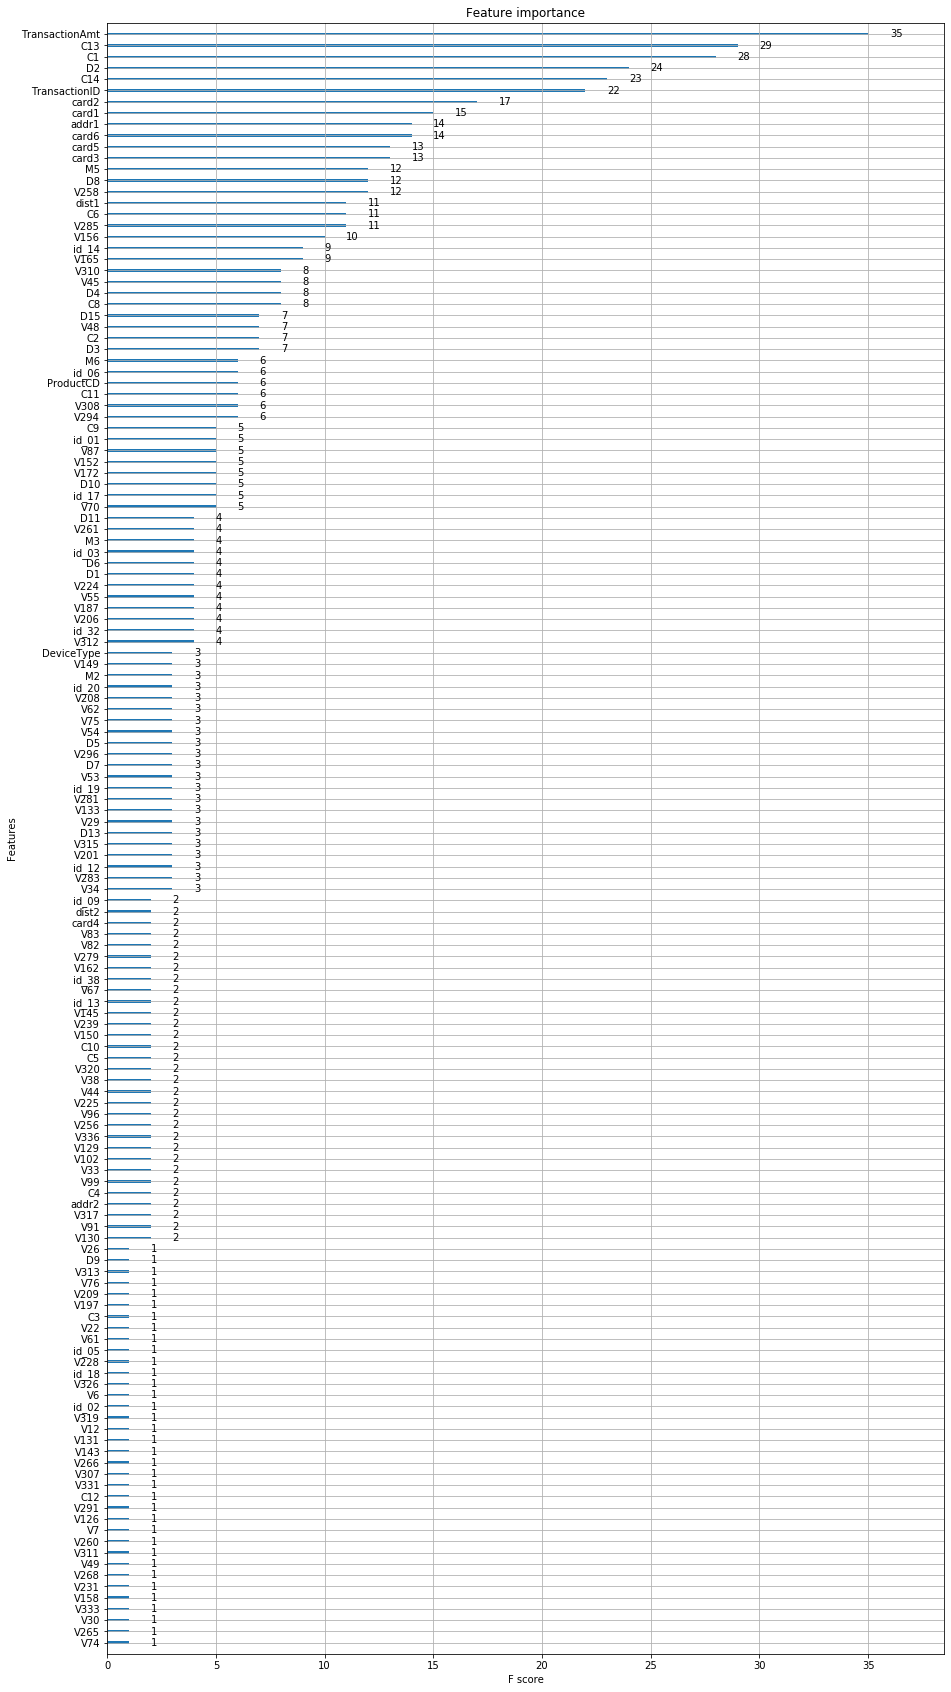

In [26]:
fig, ax = plt.subplots(figsize=(15, 30))
featureDict = XGModel.get_booster().get_fscore() #len(featureDict) = 143 
_ = plot_importance(XGModel, ax=ax) #total 421 features

Train accuracy: 0.8515644277150695
Test accuracy: 0.8492622571431797
The confusion matrix is :
[[145690  25273]
 [  1432   4767]]
The classification report is :
              precision    recall  f1-score   support

           0       0.99      0.85      0.92    170963
           1       0.16      0.77      0.26      6199

    accuracy                           0.85    177162
   macro avg       0.57      0.81      0.59    177162
weighted avg       0.96      0.85      0.89    177162

The roc_auc_score is : 0.8906845171904885


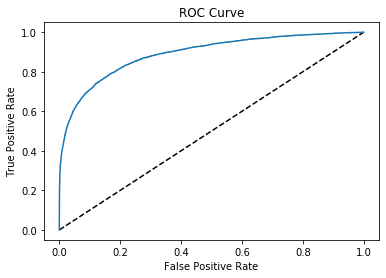

In [76]:
XGModel = XGBClassifier(top_k = 10, scale_pos_weight = ratio)
XGModel.fit(XG_train,yg_train)

y_XG_pred = XGModel.predict(XG_test)

features = XGModel.feature_importances_
yg_pred_prob = XGModel.predict_proba(XG_test)[:,1]
fpr, tpr, threshold = roc_curve(yg_test, yg_pred_prob)

# Print the accuracy and other details.
print("Train accuracy: {}".format(accuracy_score(XGModel.predict(XG_train), yg_train)))
print("Test accuracy: {}".format(accuracy_score(y_XG_pred, yg_test)))
print("The confusion matrix is :")
print(confusion_matrix(yg_test, y_XG_pred))
print("The classification report is :")
print(classification_report(yg_test, y_XG_pred))
print("The roc_auc_score is : {}".format(roc_auc_score(yg_test, yg_pred_prob)))

# Plot ROC curve
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')

Train accuracy: 0.908079288205952
Test accuracy: 0.9037829782910557
The confusion matrix is :
[[155081  15882]
 [  1164   5035]]
The classification report is :
              precision    recall  f1-score   support

           0       0.99      0.91      0.95    170963
           1       0.24      0.81      0.37      6199

    accuracy                           0.90    177162
   macro avg       0.62      0.86      0.66    177162
weighted avg       0.97      0.90      0.93    177162

The roc_auc_score is : 0.9360441647329986


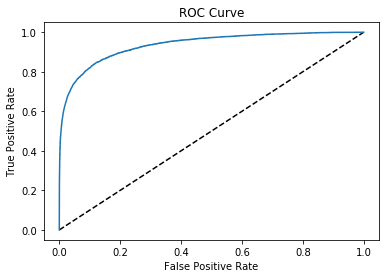

In [27]:
XGModel = XGBClassifier(top_k = 2, scale_pos_weight = ratio, learning_rate =0.1, n_estimators=143, max_depth=6, 
                        min_child_weight=3, gamma=0, subsample=0.8, colsample_bytree=0.8,
                        objective= 'binary:logistic', nthread=4, seed=27)
XGModel.fit(XG_train,yg_train)

y_XG_pred = XGModel.predict(XG_test)

features = XGModel.feature_importances_
yg_pred_prob = XGModel.predict_proba(XG_test)[:,1]
fpr, tpr, threshold = roc_curve(yg_test, yg_pred_prob)

# Print the accuracy and other details.
print("Train accuracy: {}".format(accuracy_score(XGModel.predict(XG_train), yg_train)))
print("Test accuracy: {}".format(accuracy_score(y_XG_pred, yg_test)))
print("The confusion matrix is :")
print(confusion_matrix(yg_test, y_XG_pred))
print("The classification report is :")
print(classification_report(yg_test, y_XG_pred))
print("The roc_auc_score is : {}".format(roc_auc_score(yg_test, yg_pred_prob)))

# Plot ROC curve
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')

### 8) Fitting and predicting with PCA and RandomForestClassifier using Pipeline.

Train accuracy: 1.0
Test accuracy: 0.987204871215201
The confusion matrix is :
[[166588   4375]
 [     0 170964]]
The classification report is :
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    170963
           1       0.98      1.00      0.99    170964

    accuracy                           0.99    341927
   macro avg       0.99      0.99      0.99    341927
weighted avg       0.99      0.99      0.99    341927

The roc_auc_score is : 0.999710364312558


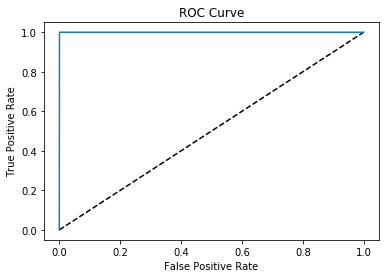

In [51]:
nonfraud_count, fraud_count = dataset.isFraud.value_counts()

data_Fraud = dataset[dataset.isFraud == 1]
data_NonFraud = dataset[dataset.isFraud == 0]

over_data_Fraud = data_Fraud.sample(nonfraud_count, replace = True)
overSData = pd.concat([data_NonFraud, over_data_Fraud], axis = 0) 

Xcols = overSData.drop(['isFraud'],axis=1).select_dtypes(exclude=[object])
y = overSData.isFraud
Xlr, Xtestlr, ylr, ytestlr = train_test_split(Xcols, y, random_state=5,test_size=0.3, stratify = y)

pca = PCA(n_components = 2)
rf = RandomForestClassifier()
pipeRF = Pipeline(steps=[('imputation',imputer), ('pca', pca), ('RandomForest', rf)])
pipeRF.fit(Xlr, ylr)
ypred = pipeRF.predict(Xtestlr)
y_pred_prob = pipeRF.predict_proba(Xtestlr)[:,1]
fpr, tpr, threshold = roc_curve(ytestlr, y_pred_prob)

# Print the accuracy and other details.
print("Train accuracy: {}".format(accuracy_score(pipeRF.predict(Xlr), ylr)))
print("Test accuracy: {}".format(accuracy_score(ypred, ytestlr)))
print("The confusion matrix is :")
print(confusion_matrix(ytestlr, ypred))
print("The classification report is :")
print(classification_report(ytestlr, ypred))
print("The roc_auc_score is : {}".format(roc_auc_score(ytestlr, y_pred_prob)))

# Plot ROC curve
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')

Accuracy: 0.9778265892914879
AUC: 0.7070226302411352
Test accuracy: 0.9777999796796153
SMOTE Confusion Matrices
............................................................
[[132725    240]
 [  2766   2062]]
[[132759    244]
 [  2837   1953]]
[[132713    233]
 [  2846   2000]]


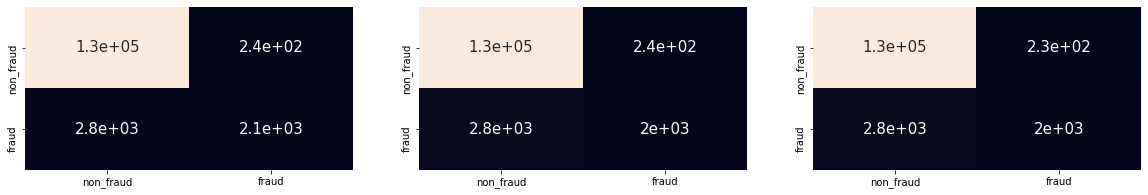

In [56]:
Xcols = dataset.drop(['isFraud'],axis=1).select_dtypes(exclude=[object])
y = dataset.isFraud

smote_cv_accuracy = []               
smote_cv_auc = []              
smote_cv_conf_matrices = []

X_train, X_test, y_train, y_test = train_test_split(Xcols, y, random_state=5,test_size=0.3, stratify = y)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

nfold = 3
for train, test in KFold(nfold).split(X_train):
    pipeline = make_pipeline_imb(SimpleImputer(missing_values = np.nan, strategy = 'median'), SMOTE(),
                                 RandomForestClassifier())
    smote_model = pipeline.fit(X_train[train], y_train[train])
    smote_predictions = smote_model.predict(X_train[test])
    
    #scoring metrics
    smote_cv_accuracy.append(pipeline.score(X_train[test], y_train[test]))
    smote_cv_auc.append(roc_auc_score(y_train[test], smote_predictions))
    
    #confusion matrices
    smote_cv_conf_matrices.append(confusion_matrix(y_train[test], smote_predictions))
    
print('Accuracy: {}'.format(np.mean(smote_cv_accuracy)))
print('AUC: {}'.format(np.mean(smote_cv_auc)))    
print("Test accuracy: {}".format(accuracy_score(pipeline.predict(X_test), y_test)))   
fig, ax = plt.subplots(figsize=(20, 3), nrows=1, ncols=3)
tick_labels = ['non_fraud', 'fraud']
k = 0
print('SMOTE Confusion Matrices')
print('.'*60)
for conf_matrix in smote_cv_conf_matrices:
    print(conf_matrix)
    ax1 = sns.heatmap(conf_matrix, cbar=False, xticklabels=tick_labels, \
                      yticklabels=tick_labels, ax=ax[k], annot=True, annot_kws={'size' : 15})
    #ax1.set_ylabel('Actual Labels')
    #ax1.set_xlabel('Predicted Labels')
    k= k + 1

Train accuracy: 0.9999308628318584
Test accuracy: 0.666317147927085
The confusion matrix is :
[[4025 2174]
 [1963 4236]]
The classification report is :
              precision    recall  f1-score   support

           0       0.67      0.65      0.66      6199
           1       0.66      0.68      0.67      6199

    accuracy                           0.67     12398
   macro avg       0.67      0.67      0.67     12398
weighted avg       0.67      0.67      0.67     12398

The roc_auc_score is : 0.7115606045769028


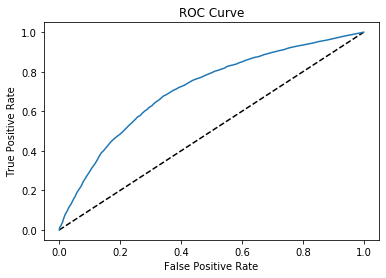

In [52]:
nonfraud_count, fraud_count = dataset.isFraud.value_counts()

data_Fraud = dataset[dataset.isFraud == 1]
data_NonFraud = dataset[dataset.isFraud == 0]

under_data_Fraud = data_NonFraud.sample(fraud_count, replace = True)
underSData = pd.concat([under_data_Fraud, data_Fraud], axis = 0) 

Xcols = underSData.drop(['isFraud'],axis=1).select_dtypes(exclude=[object])
y = underSData.isFraud
Xlr, Xtestlr, ylr, ytestlr = train_test_split(Xcols, y, random_state=5,test_size=0.3, stratify = y)

pca = PCA(n_components = 2)
rf = RandomForestClassifier()
pipeRF = Pipeline(steps=[('imputation',imputer), ('pca', pca), ('RandomForest', rf)])
pipeRF.fit(Xlr, ylr)
ypred = pipeRF.predict(Xtestlr)
y_pred_prob = pipeRF.predict_proba(Xtestlr)[:,1]
fpr, tpr, threshold = roc_curve(ytestlr, y_pred_prob)

# Print the accuracy and other details.
print("Train accuracy: {}".format(accuracy_score(pipeRF.predict(Xlr), ylr)))
print("Test accuracy: {}".format(accuracy_score(ypred, ytestlr)))
print("The confusion matrix is :")
print(confusion_matrix(ytestlr, ypred))
print("The classification report is :")
print(classification_report(ytestlr, ypred))
print("The roc_auc_score is : {}".format(roc_auc_score(ytestlr, y_pred_prob)))

# Plot ROC curve
_ = plt.plot([0, 1], [0, 1], 'k--')
_ = plt.plot(fpr, tpr)
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')